In [7]:
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

#create a transformer to convert image into data
transform = transforms.Compose([
    # transforms.Resize((64, 64)),
    # transforms.ToTensor()
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data = datasets.ImageFolder('/Users/samchen/Desktop/EuroSAT_RGB', transform = transforms.ToTensor())

#define training and testing split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])

#batch size - load the data set 32 samples of data at a time
#shuffle - so the model does not learn the order of the data
#num_workers - parallel data loaders
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)


After we load our data in, we create a neural net classifier below. For the purposes of this exercise, we think that 3 layers of convolution provides enough complexity to allow our model to discern between each of the different types of images. After each convolution layer, we use a ReLU unit to capture non-linear relationships.

In [5]:
import torch.nn as nn
import torch.optim as optim

class ImageClassifierNN(nn.Module):
    def __init__(self):
        super(ImageClassifierNN, self).__init__()
        
        #Convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size = 3, stride = 1, padding = 1)

        #pooling layer
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)

        #activation layer
        self.relu = nn.ReLU()

        #full connected layers - the vectors connect end to end to "flatten" output into a single dimensional output
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

        #dropout layer to introduce some randomness to prevent overfitting
        self.dropout = nn.Dropout(0.5)

        #forward propogation function to actually put the layers defined above into work
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 8 * 8)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model = ImageClassifierNN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Below is an example of of the code that we use to show the satellite images from a couple rows of predictions.

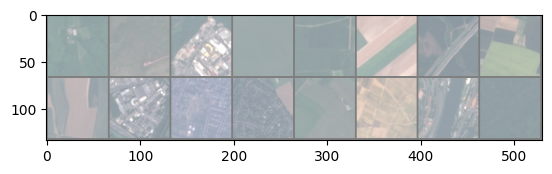

Labels: 5 2 4 9 0 0 3 0 0 4 7 7 5 6 8 1


In [8]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# Get a batch of training images and display them
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print('Labels:', ' '.join('%d' % labels[j] for j in range(16)))

Here we train the neural net with 10 epochs. For each epoch, we print 2 sample predictions.

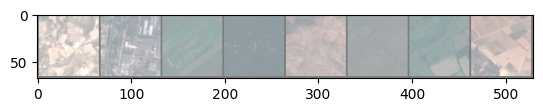

Predicted: 6 4 5 1 2 2 5 0


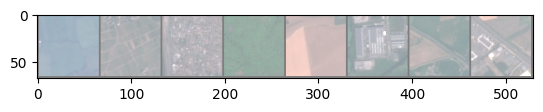

Predicted: 5 2 7 5 0 4 0 2
Epoch 1, Loss: 0.7788734768055103


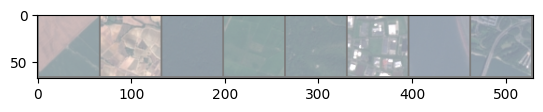

Predicted: 0 6 1 5 1 4 1 8


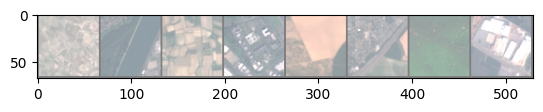

Predicted: 2 8 6 4 0 6 1 4
Epoch 2, Loss: 0.6463391940682023


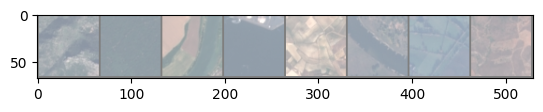

Predicted: 8 1 0 9 6 8 5 6


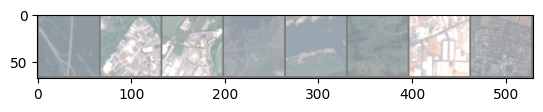

Predicted: 3 4 4 2 8 5 4 7
Epoch 3, Loss: 0.570431160374924


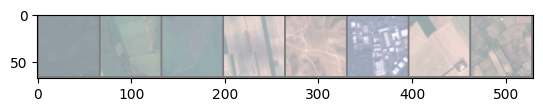

Predicted: 1 5 0 0 6 4 0 6


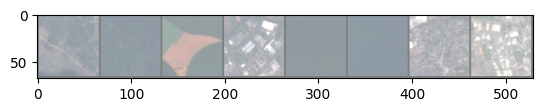

Predicted: 2 1 0 4 1 9 7 4
Epoch 4, Loss: 0.501261302696334


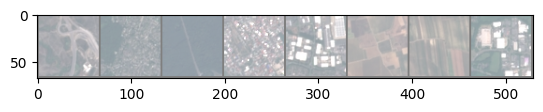

Predicted: 3 7 9 7 4 6 6 4


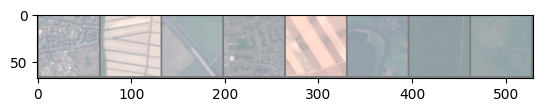

Predicted: 7 0 3 7 6 8 1 5
Epoch 5, Loss: 0.42809567641328883


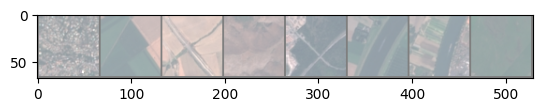

Predicted: 7 0 3 2 3 8 8 5


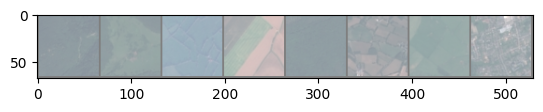

Predicted: 1 5 5 0 1 6 5 7
Epoch 6, Loss: 0.378371306459109


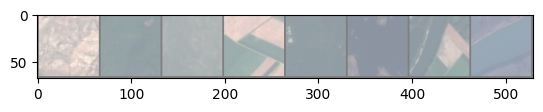

Predicted: 2 1 2 0 1 9 8 8


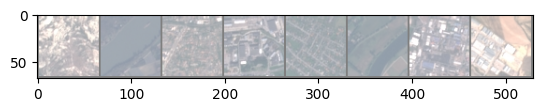

Predicted: 4 8 7 4 7 8 4 3
Epoch 7, Loss: 0.355749532762501


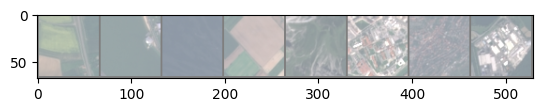

Predicted: 0 5 9 0 2 4 7 4


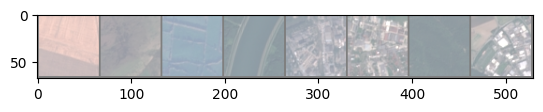

Predicted: 0 2 5 8 7 4 1 4
Epoch 8, Loss: 0.29833099414353015


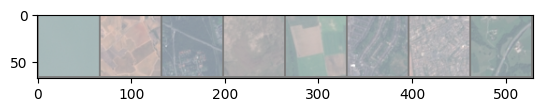

Predicted: 9 6 8 2 0 7 7 3


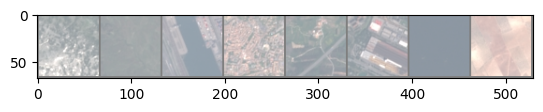

Predicted: 7 2 8 7 3 4 9 0
Epoch 9, Loss: 0.26741376800669564


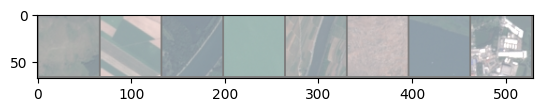

Predicted: 5 0 8 9 8 2 9 4


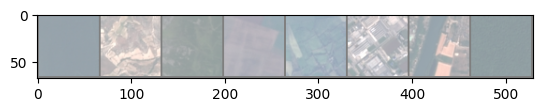

Predicted: 9 6 2 0 5 4 8 1
Epoch 10, Loss: 0.23080594544609387
Finished Training


In [16]:
# Number of training epochs
num_epochs = 10
testiter = iter(test_loader)
# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward, backward, and optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 600 == 0:
            with torch.no_grad():
                # Show a sample of images from the test data and model's predictions
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
                test_outputs = model(test_images)
                _, predicted = torch.max(test_outputs, 1)
                print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))
    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")
print('Finished Training')

The training above shows that after 10 epochs, we get our loss down to less than 0.25. Below we evaluate our model.

In [17]:
# Evaluating the model on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():  # No need to compute gradients during evaluation
    for images, labels in test_loader:
        outputs = model(images)  # Forward pass
        _, preds = torch.max(outputs, 1)  # Get the class with the highest score
        all_preds.extend(preds.numpy())  # Store predictions
        all_labels.extend(labels.numpy())  # Store true labels

# Calculate overall accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f'Overall Test Accuracy: {accuracy*100:.2f}%')

Overall Test Accuracy: 88.07%


Wow! 88% is pretty good. Below we output a confusion matrix, a strong diagonal across the self identifying line should indicate that we are making accurate predictions.

Text(0.5, 1.0, 'Confusion Matrix')

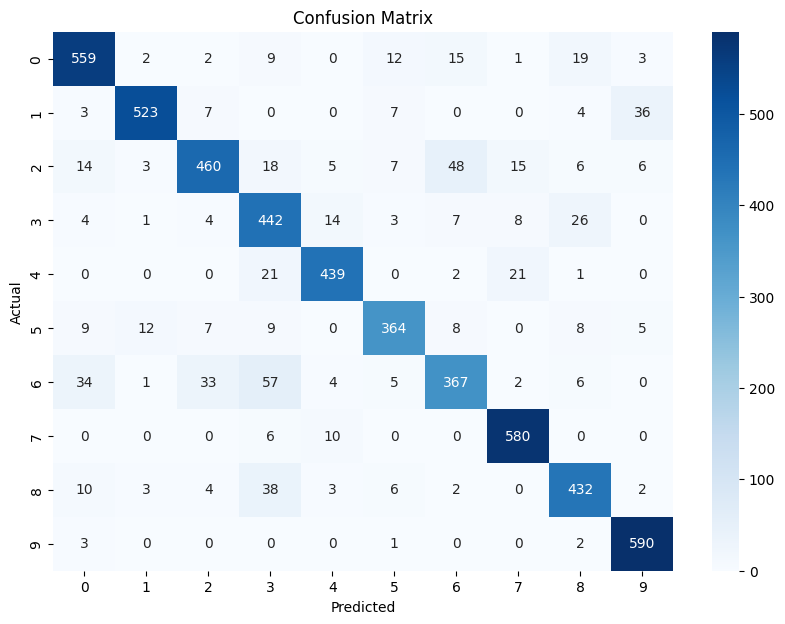

In [19]:
num_classes = 10
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')